In [1]:
import sys
import glob
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


from itertools import chain
from scipy.optimize import curve_fit

# Preprocessing of the data

For usage of the ART, it is important that each replicate is assigned a single measurement value which represents how well the replicate performed. This value is often also referred to as the *performance measure*. For our perticular project, we decided to use the activity of the alpha-amylase produces by our machines as the performance measure. However, the output of our experiments is a time-series of absorbance measures and an OD measure for each sample. In this notebook, we go over the steps on how to go from these varying data types to a single alpha-amylase activity value.

## Step 1: Loading and structuring the data

Before any preprocessing can be done, the measurement data needs to be loaded into the python environment. For easy excess, we will store these measurments in a dataframe.

In [17]:
# Storing the current working directory for later usage
cwd = os.getcwd()

# Change into the correct working directory
data_dir = os.path.join(cwd,'data','AA 5-10_1')
os.chdir(data_dir)

In [18]:
# Extract the file names of all absorbance measurement files
abs_files = glob.glob('*.TXT')
abs_files.sort()
print(abs_files)

['14.24.TXT', '14.30.TXT', '14.35.TXT', '14.39.TXT', '14.44.TXT', '14.49.TXT', '14.54.TXT', '14.59.TXT', '15.04.TXT', '15.09.TXT', '15.14.TXT', '15.19.TXT', '15.24.TXT', '16.20.TXT', '16.55.TXT']


Check wether all the listed files are intended to be used for the analysis. If there are any unwanted files, remove them using the cell below:

In [19]:
files_to_remove = [] # ['error_2111.TXT'] # More files can be removed by adding more files to this list


for file in files_to_remove:
    abs_files.remove(file) 
print(abs_files)

['14.24.TXT', '14.30.TXT', '14.35.TXT', '14.39.TXT', '14.44.TXT', '14.49.TXT', '14.54.TXT', '14.59.TXT', '15.04.TXT', '15.09.TXT', '15.14.TXT', '15.19.TXT', '15.24.TXT', '16.20.TXT', '16.55.TXT']


In [20]:


# Creating a dataframe with time measurements and reference to the absorbance measure file
abs_df = pd.DataFrame(columns=['Hour', 'Minute', 'absolute_diff', 'File_name', 'abs_measurements'])
for i, file in enumerate(abs_files):
    ms_time = file.split('.')
    ms_time = [int(string) for string in ms_time[0:2]]
    if i == 0:
        time_diff = 0
    else:
        time_diff = (ms_time[0]-abs_df['Hour'][0])*60+(ms_time[1]-abs_df['Minute'][0])
    abs_measurement = pd.read_csv(file, header = None, sep=',')
    abs_measurement = abs_measurement.iloc[:, :-1] # Due to the output format of the plate reader, there is an extra column with empty values.
    abs_df.loc[i] = [ms_time[0], ms_time[1], time_diff, file, abs_measurement]
    print(np.shape(abs_df['abs_measurements'][i]))
print(abs_df)

(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
   Hour Minute absolute_diff  File_name  \
0    14     24             0  14.24.TXT   
1    14     30             6  14.30.TXT   
2    14     35            11  14.35.TXT   
3    14     39            15  14.39.TXT   
4    14     44            20  14.44.TXT   
5    14     49            25  14.49.TXT   
6    14     54            30  14.54.TXT   
7    14     59            35  14.59.TXT   
8    15      4            40  15.04.TXT   
9    15      9            45  15.09.TXT   
10   15     14            50  15.14.TXT   
11   15     19            55  15.19.TXT   
12   15     24            60  15.24.TXT   
13   16     20           116  16.20.TXT   
14   16     55           151  16.55.TXT   

                                     abs_measurements  
0         0      1      2      3      4      5    ...  
1         0      1      2      3      4      5    ...  
2         0      1     

/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


In [21]:
# Next up, is getting the arrangement of the samples on the plate
plate_arr = pd.read_csv('plate_arrangements.csv', sep=',', dtype = str)
plate_arr = plate_arr.iloc[:, 1:] # For easy navigation, the first column is removed
plate_arr.columns = [int(col_num)-1 for col_num in plate_arr.columns] # The previous step also means that the column names need to be updated

# The dataframe of the well locations is now in exactly the same shape as the dataframes used for storing the absorbance measures
print(np.shape(plate_arr))

print(plate_arr)
print(abs_df['abs_measurements'][0])


(8, 12)
      0      1      2      3    4       5       6    7    8    9    10   11
0    #42    #42    #42    #51  #51     #51     #63  #63  #63  #01  #01  #01
1    #22    #22    #22    #23  #23     #23     #24  #24  #24  #28  #28  #28
2    #31    #31    #31    #44  #44     #44     #46  #46  #46  #47  #47  #47
3    #50    #50    #50    #52  #52     #52     #55  #55  #55  #59  #59  #59
4    #05    #05    #05    #08  #08     #08     #12  #12  #12  #19  #19  #19
5    #25    #25    #25    #32  #32     #32     #38  #38  #38  #45  #45  #45
6    NaN    NaN    NaN    #56  #56     #56     #58  #58  #58  #02  #02  #02
7  BLANK  BLANK  2nmol  2nmol  NaN  10nmol  10nmol  NaN  NaN  NaN  NaN  NaN
      0      1      2      3      4      5      6      7      8      9   \
0  0.072  0.051  0.083  0.065  0.064  0.066  0.066  0.067  0.076  0.132   
1  0.063  0.062  0.061  0.062  0.063  0.062  0.064  0.063  0.064  0.070   
2  0.062  0.064  0.062  0.062  0.061  0.061  0.062  0.063  0.063  0.064   
3  0.061

In [22]:
# Extracting the unique values out of the plate arragements
samples = plate_arr.values.flatten()
samples = np.unique(samples.astype(str)) 
samples = np.delete(samples, np.where(samples == 'nan'))
print(f'Total number of unique samples in dataset: {len(samples)-3}') # Not including the baseline and standard measurements
# After extracting the unique values, it is possible to create a disctionary where each sample is matched with the corresponding absorbance measure
sample_dict = {}
for sample in samples:
    coordinates = np.array(np.where(plate_arr == sample)).T
    for i, coord in enumerate(coordinates):
        sample_name = sample + '_r' + str(i)
        sample_dict[sample_name] = [measurement[coord[1]][coord[0]] for measurement in abs_df['abs_measurements']]
print(sample_dict)

Total number of unique samples in dataset: 27
{'#01_r0': [0.132, 0.162, 0.189, 0.214, 0.241, 0.268, 0.297, 0.323, 0.352, 0.377, 0.403, 0.429, 0.454, 0.691, 0.792], '#01_r1': [0.135, 0.165, 0.191, 0.216, 0.244, 0.271, 0.3, 0.327, 0.355, 0.381, 0.408, 0.434, 0.459, 0.702, 0.805], '#01_r2': [0.138, 0.168, 0.196, 0.221, 0.25, 0.277, 0.306, 0.333, 0.362, 0.388, 0.414, 0.441, 0.466, 0.709, 0.814], '#02_r0': [0.066, 0.066, 0.066, 0.067, 0.067, 0.067, 0.068, 0.068, 0.068, 0.068, 0.068, 0.069, 0.069, 0.071, 0.072], '#02_r1': [0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.066, 0.066, 0.066, 0.067, 0.067, 0.067, 0.067, 0.069, 0.07], '#02_r2': [0.066, 0.067, 0.068, 0.068, 0.068, 0.068, 0.068, 0.068, 0.069, 0.069, 0.068, 0.068, 0.068, 0.07, 0.071], '#05_r0': [0.063, 0.065, 0.066, 0.067, 0.068, 0.07, 0.071, 0.072, 0.073, 0.075, 0.076, 0.077, 0.079, 0.093, 0.102], '#05_r1': [0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.07, 0.071, 0.072, 0.074, 0.075, 0.076, 0.078, 0.092, 0.101], '#05_r2': [0.064, 0.065,

In [23]:
# The final dataframe that needs to be loaded are the OD measures for each sample

OD_measures = pd.read_csv('OD_standerdized.csv', sep=',')
print(OD_measures)


     sample  Dilution(%)  OD (raw)  OD (stadardized)
0        42            5     0.079             0.048
1        51            5     0.107             0.076
2        63            5     0.120             0.092
3         1            5     0.129             0.101
4        22            5     0.122             0.094
5        23            5     0.138             0.110
6        24            5     0.108             0.080
7        28            5     0.107             0.079
8        31            5     0.101             0.073
9        44            5     0.121             0.093
10       46            5     0.112             0.084
11       47            5     0.126             0.098
12       50            5     0.126             0.098
13       52            5     0.117             0.086
14       55            5     0.107             0.076
15       59            5     0.110             0.079
16        5            5     0.121             0.090
17        8            5     0.130            

## Step 2: Checking the baseline absorbance 

The data currently stored in sample_dict cannot be used yet. The following data preprocessing steps need to be taken first:

1. Check the baseline absorbance and check whether the measured samples need to be accounted for a changing baseline
2. Remove any values above the 10nmol standard. 

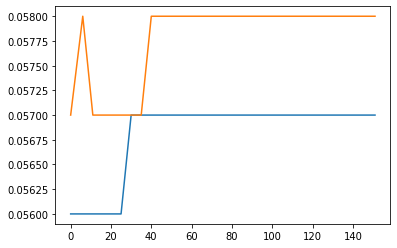

In [24]:
plt.plot(abs_df['absolute_diff'], sample_dict['BLANK_r0'])
plt.plot(abs_df['absolute_diff'], sample_dict['BLANK_r1'])

The plots shown above show the standard of the blank well. This should show a flat horizontal line. If they are not flat, this would be a possible indication that something went wrong with the measurements. Before moving on, please ensure these curves are in the correct shape, or if they are not, that the unusual shape can be explained. 

If the blank standard is at it should be, the next step is checking whether there are any datapoints that show an obsorbance which is higher than the 10nmol standard. Measurements above this standard are not reliable and thus cannot be used as input for the ART. Measurements of the same replicate taken before the absorbance exceeded the standard can still be used as training data for the ART.

In [25]:
def correct_sample_by_standard(standard, sample, sample_name):
    rest = np.subtract(standard, sample)
    corrected_sample = sample
    for i, d_measurement in enumerate(rest):
        if d_measurement < 0:  # If d_measurement is less then 0, it means that absorbance measure in the sample has exceeded the 10 nmol standard
            corrected_sample = sample[:i]
            print(f'Shortening the time series of sample {sample_name} to length {len(corrected_sample)}')
            break
    return corrected_sample

avg_10nmol_standard = np.average([sample_dict['10nmol_r0'],sample_dict['10nmol_r1']], axis=0)

for sample, measurement in sample_dict.items():
    if ('#' in sample): # Only check the actual samples and skip the standard and baseline measurements
        sample_dict[sample] = correct_sample_by_standard(avg_10nmol_standard, measurement, sample)


Shortening the time series of sample #01_r0 to length 13
Shortening the time series of sample #01_r1 to length 13
Shortening the time series of sample #01_r2 to length 13


## Step 3: Determine alpha-amylase activity of each sample

The alpha-amylase activity of a sample is determined by the change in absorbance over time. This change in absorbance is linear with respect to time. Therefore, it is possible to fit a linear curve to each sample in order to abtain a function in the form of $absorbance = a*t+b$, where $a$ is the change in absorbance over time (i.e. the alpha-amylase activity), $t$ is the time and $b$ is some offset. 

Under perfect conditions, $b$ would be 0. However, preparing the samples takes some time. This means that at the time of the first measurement, some samples already had the time to **X** for about 15 minutes while others were only prepared one minute in advance. This means that $b$ will not be 0 for most of our samples.

For our analysis, the exact value of $b$ is irrelevant as the main interest lies within the change in absobance (i.e. $a$). The value of $b$ is only needed in order to fit the linear curve better to the datapoints. Once the curve has been fitted, the $a$ value is used and interpreted as the alpha-amylase activity of the sample. 

It is however important to first validate wether the absorbance measures indeed follow a linear pattern with respect to time. 

Sample #01_r0 fits the linear curve with an R^2 of 0.9996609351966532
Sample #01_r1 fits the linear curve with an R^2 of 0.9997187305006582
Sample #01_r2 fits the linear curve with an R^2 of 0.9996189127835107
Sample #02_r0 fits the linear curve with an R^2 of 0.9556633051067814
Sample #02_r1 fits the linear curve with an R^2 of 0.9523939808481529
The absorbance measure of sample #02_r2:
[0.066, 0.067, 0.068, 0.068, 0.068, 0.068, 0.068, 0.068, 0.069, 0.069, 0.068, 0.068, 0.068, 0.07, 0.071]
Sample #05_r0 fits the linear curve with an R^2 of 0.9993933118875061
Sample #05_r1 fits the linear curve with an R^2 of 0.9988495369888095
Sample #05_r2 fits the linear curve with an R^2 of 0.9964400611970603
Sample #08_r0 fits the linear curve with an R^2 of 0.9949199765376235
Sample #08_r1 fits the linear curve with an R^2 of 0.9967184302164831
Sample #08_r2 fits the linear curve with an R^2 of 0.9961541434359288
Sample #12_r0 fits the linear curve with an R^2 of 0.9922913064598073
Sample #12_r1 

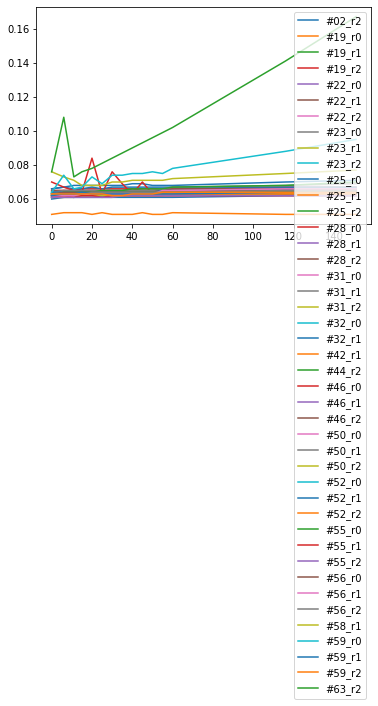

In [26]:

# Defining a linear curve
def linear_curve(x, a, b):
    return a * x + b

# Calculating R^2. For an explanation, see https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
def determine_R2(xdata, ydata, popt):
    residuals = ydata - linear_curve(xdata, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

activity_dict={}
for sample in sample_dict:
    if ('#' in sample): # Only analize the samples and not the standards
        ydata = sample_dict[sample]
        xdata = abs_df['absolute_diff'][:len(ydata)] # As some samples might have been corrected for exceeding the standard, the length of the xdata might need to be shortened as well for that perticular sample
        popt, pcov = curve_fit(linear_curve, xdata, ydata)
        a, b = popt
        activity_dict[sample] = a # As explaine above, the slope of the curve is anagolous to the activity of the sample
        R_squared = determine_R2(xdata, ydata, popt)

        # The R^2 value represents how well the y-value can be explained by the x-value by some function f(). In this case,
        # the f() function is a first order polynomial (i.e. a linear curve) in the form of f(x)=y=a*x+b. The downside of using 
        # the R^2 value for representing the fit to a linear curve, is that is there is no slope (i.e. a=0), the R^2 value is 0
        # as well. Therefore, all absorbance measures that have a R^2 value of less than 0.95 need to be manually verified on whether
        # they are in fact linear curves. 
        if R_squared < 0.95: 
            plt.plot(xdata, ydata, label=sample)
            #print(f'R^2 value of sample {sample}: {R_squared}')
            print(f'The absorbance measure of sample {sample}:')
            print(ydata)
        else:
            print(f'Sample {sample} fits the linear curve with an R^2 of {R_squared}')
plt.legend()

Based on the figure created in the cell above, it should be possible to locate any sample that does not show the expected linear behavior. In order to exclude this sample, along with other replicates of the same sample, enter the name of this sample in the in the cell below

In [27]:

samples_to_exclude = ['#17', '#21', '#40', '#43', '#64', '#57'] # for example: ['#26', '#17'] in order to exclude all replicates of samples 26 and 17


print(f'Samples in dictionary before removal: {activity_dict.keys()}')
for sample in samples_to_exclude:
    activity_dict = dict(filter(lambda elem: sample not in elem[0], activity_dict.items()))
print(f'Samples in dictionary after removal: {activity_dict.keys()}')

Samples in dictionary before removal: dict_keys(['#01_r0', '#01_r1', '#01_r2', '#02_r0', '#02_r1', '#02_r2', '#05_r0', '#05_r1', '#05_r2', '#08_r0', '#08_r1', '#08_r2', '#12_r0', '#12_r1', '#12_r2', '#19_r0', '#19_r1', '#19_r2', '#22_r0', '#22_r1', '#22_r2', '#23_r0', '#23_r1', '#23_r2', '#24_r0', '#24_r1', '#24_r2', '#25_r0', '#25_r1', '#25_r2', '#28_r0', '#28_r1', '#28_r2', '#31_r0', '#31_r1', '#31_r2', '#32_r0', '#32_r1', '#32_r2', '#38_r0', '#38_r1', '#38_r2', '#42_r0', '#42_r1', '#42_r2', '#44_r0', '#44_r1', '#44_r2', '#45_r0', '#45_r1', '#45_r2', '#46_r0', '#46_r1', '#46_r2', '#47_r0', '#47_r1', '#47_r2', '#50_r0', '#50_r1', '#50_r2', '#51_r0', '#51_r1', '#51_r2', '#52_r0', '#52_r1', '#52_r2', '#55_r0', '#55_r1', '#55_r2', '#56_r0', '#56_r1', '#56_r2', '#58_r0', '#58_r1', '#58_r2', '#59_r0', '#59_r1', '#59_r2', '#63_r0', '#63_r1', '#63_r2'])
Samples in dictionary after removal: dict_keys(['#01_r0', '#01_r1', '#01_r2', '#02_r0', '#02_r1', '#02_r2', '#05_r0', '#05_r1', '#05_r2', '#

## Step 4: Correcting for OD

The starting conditions of the overnight cultures were not completely equal across all samples. In order to prevent samples that started their overnight cultures with a higher cell count from yielding the best results, it is necesarry to first account for the number of cells in each sample. The Optical Density (OD) of the sample before **X(forgot how it is called)** was used as a proxy for this cell count. Under the assumption that there is a linear relation between cell count, OD and alpha-amylase activity, the alpha-amylase activity per cell unit can be derived by deviding the overall alpha-amylase activity of a sample with the OD of that sample. 

Another issue is that the linearity of the OD with respect to the number of cells no longer holds after the sample has reached an OD of **X (enter exact value)** and values onder a **Y (enter exact value)** contain a substantial about of measuring error. Therefore, each sample was diluted to either 2.5%, 1% or .5% depending on which level of dilution yielded an OD between **X** and **Y**. 

Therefore, the first step is to determine how many cell units there were in the original sample by deviding the measured OD over the concentration of the diluted mixture. Afterwards, the alpha-amylase activity per cell unit is determined by deviding the total alpha-amylase activity of a sample over the number of cell units within that sample.

In [28]:
OD_measures['cell_units'] = OD_measures['OD (stadardized)']/(OD_measures['Dilution(%)']/100)
print(OD_measures)

     sample  Dilution(%)  OD (raw)  OD (stadardized)  cell_units
0        42            5     0.079             0.048        0.96
1        51            5     0.107             0.076        1.52
2        63            5     0.120             0.092        1.84
3         1            5     0.129             0.101        2.02
4        22            5     0.122             0.094        1.88
5        23            5     0.138             0.110        2.20
6        24            5     0.108             0.080        1.60
7        28            5     0.107             0.079        1.58
8        31            5     0.101             0.073        1.46
9        44            5     0.121             0.093        1.86
10       46            5     0.112             0.084        1.68
11       47            5     0.126             0.098        1.96
12       50            5     0.126             0.098        1.96
13       52            5     0.117             0.086        1.72
14       55            5 

In order to account for the un-equal cell counts at the beginning of the incubation period of each sample, the activity for each replicate is divided by the number of cell units within the original sample.

{'#01_r0': 0.001329548277172303, '#01_r1': 0.0013407029855833914, '#01_r2': 0.0013558970497717848, '#02_r0': 1.7394018030810365e-05, '#02_r1': 1.5469294289767543e-05, '#02_r2': 1.051626056922813e-05, '#05_r0': 7.939458982104017e-05, '#05_r1': 7.906745745199785e-05, '#05_r2': 8.271214822098207e-05, '#08_r0': 4.808251043164043e-05, '#08_r1': 5.070029030587118e-05, '#08_r2': 4.8751554664821364e-05, '#12_r0': 0.0001557368167984192, '#12_r1': 0.0002042559992966266, '#12_r2': 0.00017635160805026099, '#19_r0': 4.274673129286449e-05, '#19_r1': 3.922830949248863e-05, '#19_r2': 6.436829416223319e-05, '#22_r0': 1.449037569570137e-06, '#22_r1': 4.065622379252974e-06, '#22_r2': 2.6757621272440186e-06, '#23_r0': 1.322696477185632e-06, '#23_r1': 1.6345366428968608e-06, '#23_r2': 1.6549757413732118e-06, '#24_r0': 0.00013315878102298508, '#24_r1': 0.00013018661990338282, '#24_r2': 0.00013724163840596286, '#25_r0': 3.12913576405264e-06, '#25_r1': 8.636480488936158e-06, '#25_r2': 5.2548075850271025e-06, 

<BarContainer object of 81 artists>

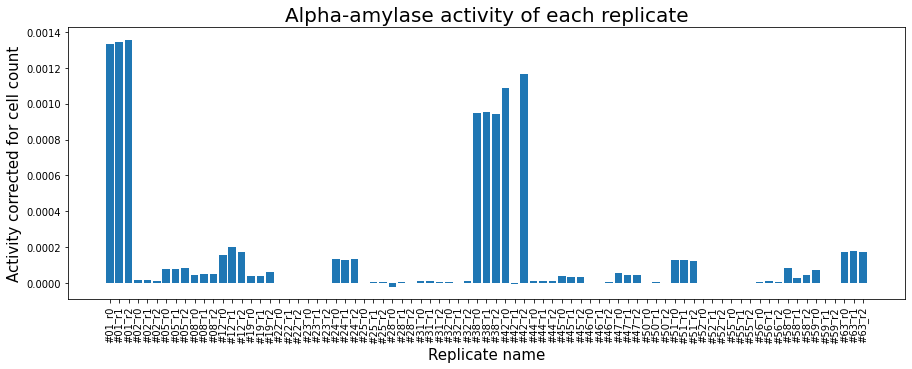

In [36]:

for sample in activity_dict:
    sample_number = re.findall(r'^(?:#)(\d\d)', sample) # some RegEX for finding the sample number
    if len(sample_number)>0:
        sample_number = int(sample_number[0])
        activity_dict[sample] = activity_dict[sample]/OD_measures.loc[OD_measures['sample']==str(sample_number)].iloc[0]['cell_units']

print(activity_dict)

fig, ax = plt.subplots(figsize=(15, 5))
ax.tick_params(axis='x', rotation=90)
ax.set_title('Alpha-amylase activity of each replicate',fontsize=20)
ax.set_ylabel('Activity corrected for cell count', fontsize=15)
ax.set_xlabel('Replicate name', fontsize=15)
plt.bar(activity_dict.keys(), activity_dict.values())
# plt.xticks(rotation=90)

It is possible that some replicates show a completely different value then the other replicates of the same sample. This absolutely fine. The actual outlier detection is handled by the ART, so these 'weird' values can remain in the input data for the ART.

## Step 5: Decrease the order of magnitude of the variance within the activity measures

Most activity values are in between the range of $5*10^{-6}$ and $1*10^{-4}$. While there is already an order of magnitude between these values, some values go as high $3*10^{-3}$. This means that there is a difference of almost three orders of magnitude between the lowest and the highest activity measures. The difference in the lower activity value ranges are therefore close to non-existant in comparison to the total spread of activity values. These differences in lower activity values are however important when training the ART. If most activity measures are considered to be 0, there is not much data to train on. Therefore, a way is needed to to project the activity measures which can vary multiple orders of magnitude onto data points which vary only on a single order of magnitude. Taking the natural logarithm is on of the ways of achieving this.

A prerequisite for being able to do this, is that all activity values need to be greater than 0. This is a fair assumption as a negative activity would imply that our enzyme actually creates starch instead of breaking it down. There are however measuring errors that could result in a very small negative activity. Under the assumption that it would not matter if this measuring error is either positive or negative, it is possible to take the absolute activity values to get rid of the negative values.

<BarContainer object of 81 artists>

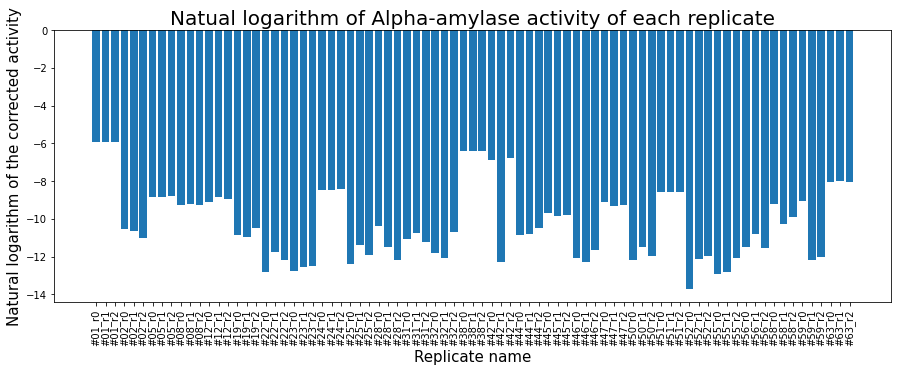

In [35]:
zipped_corrected_activities = zip(activity_dict.keys(), np.log(abs(np.array(list(activity_dict.values())))))
corrected_activity_dict = dict(zipped_corrected_activities)

fig, ax = plt.subplots(figsize=(15, 5))
ax.tick_params(axis='x', rotation=90)
ax.set_title('Natual logarithm of Alpha-amylase activity of each replicate',fontsize=20)
ax.set_ylabel('Natural logarithm of the corrected activity', fontsize=15)
ax.set_xlabel('Replicate name', fontsize=15)
plt.bar(corrected_activity_dict.keys(), corrected_activity_dict.values())

Instead of having values that vary several order of magnitude, all values should now be somewhere between -5 and -40

## Step 6: Match the strain name with the strain, promoter, secretion peptide and gene combination and export the results

Once the activity of each sample has been determined, this activity needs to be matched to combination of parts used for creating the sample. The end result is a file in which can be directly used by the ART pipeline.  

In [31]:
os.chdir(cwd) # set the working directory back to the orignal one

results = pd.read_csv('Sample_list.csv', sep=',') # load in the file contianing the link of the sample name to the various parts
for sample in activity_dict:
    line_name, replicate = sample.split('_')
    
    # Adding the measured activity to the results
    results.loc[(results['Line Name']==line_name) & (results['Replicate']==replicate), 'Measurement'] = corrected_activity_dict[sample]
    print(f'Updated entry of line {line_name}')
    print(results.loc[(results['Line Name']==line_name) & (results['Replicate']==replicate)])
# Write the results into the original file
results.to_csv('Sample_list.csv', sep=',', index=False) 

Updated entry of line #01
  Line Name Replicate Measurement  str_idx  pro_idx  sec_idx  gen_idx
0       #01        r0   -5.919819        2        6       16       22
Updated entry of line #01
  Line Name Replicate Measurement  str_idx  pro_idx  sec_idx  gen_idx
1       #01        r1   -5.911464        2        6       16       22
Updated entry of line #01
  Line Name Replicate Measurement  str_idx  pro_idx  sec_idx  gen_idx
2       #01        r2   -5.900195        2        6       16       22
Updated entry of line #02
  Line Name Replicate Measurement  str_idx  pro_idx  sec_idx  gen_idx
3       #02        r0  -10.527602        4       11       18       19
Updated entry of line #02
  Line Name Replicate Measurement  str_idx  pro_idx  sec_idx  gen_idx
4       #02        r1  -10.644871        4       11       18       19
Updated entry of line #02
  Line Name Replicate Measurement  str_idx  pro_idx  sec_idx  gen_idx
5       #02        r2  -11.030805        4       11       18       19
Upda